# Speech Recognition with AI
Brought to you by Daniel Sikar - daniel.sikar@city.ac.uk
and
City Data Science Society - https://www.datasciencesociety.city/

## Natural Language Processing with Convolutional Neural Networks

From https://github.com/CityDataScienceSociety/ComputerVisionWorkshops/tree/main/detect-fire-with-AI

Using a subset ("yes" and "no") of Tensorflow's Speech Commands Datasets. The full set consists of 30 words plus a background noise set: _background_noise_, bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, no, nine, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero.


In [125]:
# Get the data subset
# Install PyDrive
!pip install PyDrive

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the shareable link e.g. https://drive.google.com/file/d/1OrH0BKJUSvdl4P65b8XK2CoXcbCiIHnI/view?usp=sharing
# Get the id from the link 1JYdxKasFKNfVqx2Iklj7iv_bwPanmi4j
downloaded = drive.CreateFile({'id':"1OrH0BKJUSvdl4P65b8XK2CoXcbCiIHnI"})   
downloaded.GetContentFile('input.tar.gz')   
# Alternatively, if you are running the notebook locally, file can be downloaded by pasting shareable link
# into browser

In [ ]:
# list
# !ls
# unpack
# !tar xvf input.tar.gz
# !ls input/training_data
# !ls input/training_data/no
# !ls input/training_data/yes

In [24]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

In [136]:
# what is the space available?
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   33G   76G  30% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G  4.0K  5.9G   1% /dev/shm
tmpfs           6.4G   32K  6.4G   1% /var/colab
/dev/sda1       114G   37G   78G  32% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way. 

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

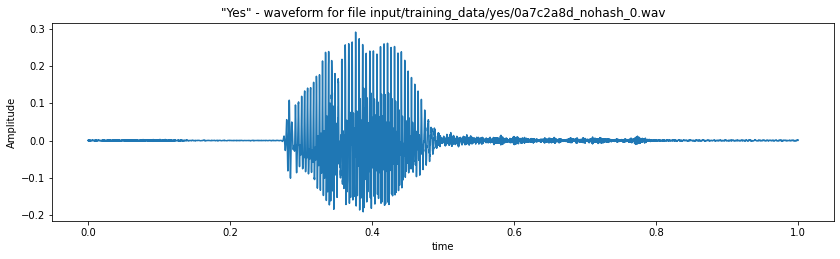

In [142]:
# about 20 Hz to 20 kHz
# Humans can detect sounds in a frequency range from about 20 Hz to 20 kHz.
train_audio_path = 'input/training_data/'
samples, sample_rate = librosa.load(train_audio_path + 'yes/0a7c2a8d_nohash_0.wav', sr = 8000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"Yes" - waveform for file ' + 'input/training_data/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
ipd.Audio(samples, rate=sample_rate)

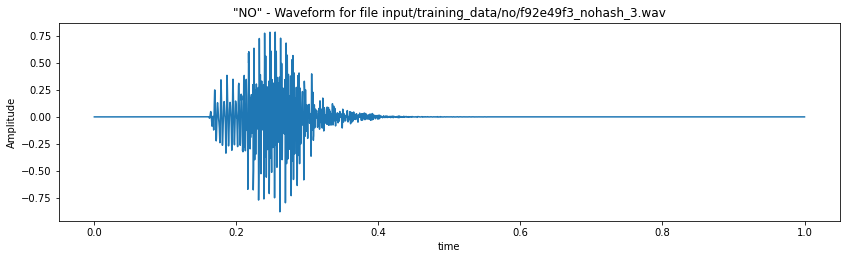

In [147]:
train_audio_path = 'input/training_data/'
samples, sample_rate = librosa.load(train_audio_path + 'no/f92e49f3_nohash_3.wav', sr = 8000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('"NO" - Waveform for file ' + 'input/training_data/no/f92e49f3_nohash_3.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
ipd.Audio(samples, rate=sample_rate)

In [152]:
print(type(samples))
print(samples.shape)

<class 'numpy.ndarray'>
(8000,)


In [ ]:
# Human voice: 
# In telephony, the usable voice frequency band ranges from approximately 300 to 3400 Hz
# The bandwidth allocated for a single voice-frequency transmission channel is usually 4 kHz
# Per the Nyquist–Shannon sampling theorem, the sampling frequency (8 kHz) must be at least twice 
# the highest component of the voice frequency via appropriate filtering prior to sampling at discrete 
# times (4 kHz) for effective reconstruction of the voice signal. 

# TODO plot frequency x ampliture

In [155]:
labels=os.listdir(train_audio_path)
print("Audio labels: ", labels)

Audio labels:  ['no', 'yes']


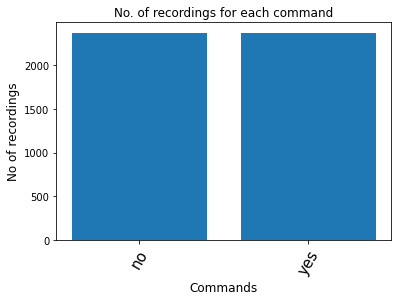

In [157]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure()
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

**Duration of recordings**

What’s next? A look at the distribution of the duration of recordings:

(array([8.000e+00, 3.000e+00, 1.200e+01, 2.200e+01, 4.900e+01, 4.000e+01,
        8.400e+01, 6.400e+01, 1.230e+02, 4.343e+03]),
 array([0.4645 , 0.51805, 0.5716 , 0.62515, 0.6787 , 0.73225, 0.7858 ,
        0.83935, 0.8929 , 0.94645, 1.     ]),
 <a list of 10 Patch objects>)

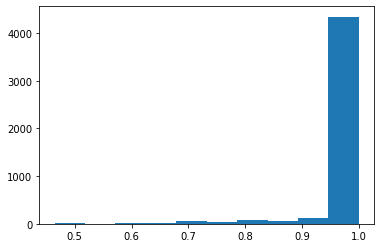

In [158]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

**Preprocessing the audio waves**

In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

Here are the two steps we’ll follow:

* Resampling
* Removing shorter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [159]:
# 743s execution time
train_audio_path = 'input/training_data'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 8000)
        #samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

no
yes


Convert the output labels to integer encoded:

In [162]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
type(labels)

list

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [163]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [164]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [166]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture for this problem**

We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 

**Model building**

Let us implement the model using Keras functional API.

In [168]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [169]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [170]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [171]:
# execution time 258s
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/10
107/107 [==============================] - 27s 240ms/step - loss: 0.6701 - accuracy: 0.5797 - val_loss: 0.5922 - val_accuracy: 0.6675
Epoch 2/10
107/107 [==============================] - 25s 237ms/step - loss: 0.5187 - accuracy: 0.7645 - val_loss: 0.5033 - val_accuracy: 0.7673
Epoch 3/10
107/107 [==============================] - 25s 237ms/step - loss: 0.4181 - accuracy: 0.8153 - val_loss: 0.3901 - val_accuracy: 0.8214
Epoch 4/10
107/107 [==============================] - 25s 238ms/step - loss: 0.3478 - accuracy: 0.8565 - val_loss: 0.3739 - val_accuracy: 0.8331
Epoch 5/10
107/107 [==============================] - 25s 237ms/step - loss: 0.2937 - accuracy: 0.8838 - val_loss: 0.2994 - val_accuracy: 0.8672
Epoch 6/10
107/107 [==============================] - 25s 237ms/step - loss: 0.2527 - accuracy: 0.8922 - val_loss: 0.3440 - val_accuracy: 0.8461
Epoch 7/10
107/107 [==============================] - 27s 256ms/step - loss: 0.2399 - accuracy: 0.9061 - val_loss: 0.2894 - val_ac

**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

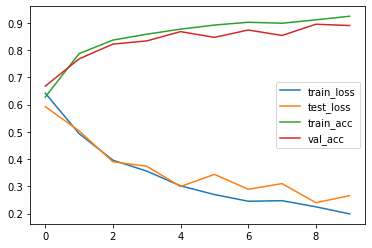

In [172]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
pyplot.legend()
pyplot.show()

**Loading the best model**

In [173]:
from keras.models import load_model
model=load_model('best_model.hdf5')

OSError: ignored

Define the function that predicts text for the given audio:

In [174]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return prob, classes[index]

Prediction time! Make predictions on the validation data:

In [181]:
import random
print("len(x_val):", len(x_val))
index=random.randint(0,len(x_val)-1)
print("index:", index)
samples=x_val[index].ravel() # x_val[index] shape: (8000, 1), "samples" shape: (8000,)
print("x_val[index]:", x_val[index])
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

len(x_val): 851
index: 150
x_val[index]: [[ 0.0000000e+00]
 [ 3.0517578e-05]
 [ 3.0517578e-05]
 ...
 [-3.0517578e-05]
 [-3.3569336e-04]
 [-3.9672852e-04]]
Audio: yes


In [113]:
# x_val[index].shape
# (8000, 1)
# x_val[index]: x_val[index]: [[ 0.00422602]
# [ 0.01268432]
# [ 0.00283716]
# ...
# xr = x_val[index].ravel()
# type(xr) # numpy.ndarray
# type(x_val[index]) # numpy.ndarray
# xr.shape # (8000,)
# xr: array([-0.00036546, -0.00062576,  0.00048751, ..., -0.0003528 ,
y_val[index]

array([1., 0.], dtype=float32)